# Sea-ice and Lead Classification

📘 **Interactive Version**: For a hands-on experience with this chapter's content, access the interactive notebook in [Google Colab](https://drive.google.com/file/d/1BYjnA1Q_l-756SF8I0ty2mwE8RH1wx8h/view?usp=sharing).

## Intro to Sea-ice & Lead Classification

### Definition and Importance

Sea ice leads are narrow, linear fractures or openings in sea ice that form when the ice is broken by the movement of ocean waters or by the stress induced by wind and temperature changes. These leads can vary in size, ranging from a few meters to several kilometers in width, and can extend for hundreds of kilometers. They play a crucial role in the polar climate system and are vital for marine navigation and ecosystem dynamics.

(Here we may put some images of sea-ice/leads)

Sea ice leads are important for several reasons:

- **Heat Exchange:** They act as a gateway for the exchange of heat, moisture, and momentum between the ocean and the atmosphere, influencing weather and climate patterns.
- **Marine Life:** Sea ice leads are essential for various marine species, providing access to the surface for air-breathing animals like seals and serving as feeding grounds for polar bears.
- **Navigation:** For human activities, they offer potential navigation routes and access to remote polar regions.
- **Carbon Cycle:** They contribute to the oceanic uptake of atmospheric CO2, playing a role in the global carbon cycle.

#### Ocean and Land Colour Instrument (OLCI)
OLCI is a state-of-the-art imaging spectrometer aboard Sentinel-3, capturing high-resolution optical imagery across 21 distinct bands, ranging from the visible to the near-infrared spectrum. It offers detailed observations of various geographical features and is pivotal for applications like monitoring water quality, assessing vegetation health, analysing land cover changes, and detecting environmental anomalies. This dataset will be primarily used in this example of image classification.

#### Data Preprocessing
The OLCI datasets are natively provided in the netCDF4 format. For integration into Machine Learning workflows, it is imperative to transform these datasets into array structures. The subsequent code delineates this transformation process.

At the moment, you don't need to run the following code block because we will provide the numpy arrays of the image that you can use for extracting data from IRIS. But make sure you understand them as it may be useful for your exercise.


In [ ]:
!pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.2 MB/s eta 0:00:00


In [ ]:
import os
import netCDF4
import numpy as np
import re

# Define the path to the main folder where your data is stored.
# You need to replace 'path/to/data' with the actual path to your data folder.
main_folder_path = '/content/drive/MyDrive/GEOL0069/Week 3'

# This part of the code is responsible for finding all directories in the main_folder that end with '.SEN3'.
# '.SEN3' is the format of the folder containing specific satellite data files (in this case, OLCI data files).
directories = [d for d in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, d)) and d.endswith('.SEN3')]

# Loop over each directory (i.e., each set of data) found above.
for directory in directories:
    # Construct the path to the OLCI data file within the directory.
    # This path is used to access the data files.
    OLCI_file_p = os.path.join(main_folder_path, directory)

    # Print the path to the current data file being processed.
    # This is helpful for tracking which file is being processed at any time.
    print(f"Processing: {OLCI_file_p}")

    # Load the instrument data from a file named 'instrument_data.nc' inside the directory.
    # This file contains various data about the instrument that captured the satellite data.
    instrument_data = netCDF4.Dataset(OLCI_file_p + '/instrument_data.nc')
    solar_flux = instrument_data.variables['solar_flux'][:]  # Extract the solar flux data.
    detector_index = instrument_data.variables['detector_index'][:]  # Extract the detector index.

    # Load tie geometries from a file named 'tie_geometries.nc'.
    # Tie geometries contain information about viewing angles, which are important for data analysis.
    tie_geometries = netCDF4.Dataset(OLCI_file_p + '/tie_geometries.nc')
    SZA = tie_geometries.variables['SZA'][:]  # Extract the Solar Zenith Angle (SZA).

    # Create a directory for saving the processed data using the original directory name.
    # This directory will be used to store output files.
    save_directory = os.path.join('/content/drive/MyDrive/GEOL0069/Week 3')
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # This loop processes each radiance band in the OLCI data.
    # OLCI instruments capture multiple bands, each representing different wavelengths.
    OLCI_data = []
    for Radiance in range(1, 22):  # There are 21 bands in OLCI data.

        Rstr = "%02d" % Radiance  # Formatting the band number.
        solar_flux_band = solar_flux[Radiance - 1]  # Get the solar flux for the current band.

        # Print information about the current band being processed.
        # This includes the band number and its corresponding solar flux.
        print(f"Processing Band: {Rstr}")
        print(f"Solar Flux for Band {Rstr}: {solar_flux_band}")

        # Load radiance values from the OLCI data file for the current band.
        OLCI_nc = netCDF4.Dataset(OLCI_file_p + '/Oa' + Rstr + '_radiance.nc')
        radiance_values = np.asarray(OLCI_nc['Oa' + Rstr + '_radiance'])

        # Initialize an array to store angle data, which will be calculated based on SZA.
        angle = np.zeros_like(radiance_values)
        for x in range(angle.shape[1]):
            angle[:, x] = SZA[:, int(x/64)]

        # Calculate the Top of Atmosphere Bidirectional Reflectance Factor (TOA BRF) for the current band.
        TOA_BRF = (np.pi * radiance_values) / (solar_flux_band[detector_index] * np.cos(np.radians(angle)))

        # Add the calculated TOA BRF data to the OLCI_data list.
        OLCI_data.append(TOA_BRF)

        # Print the range of reflectance values for the current band.
        print(f"Reflectance Values Range for Band {Rstr}: {np.nanmin(TOA_BRF)}, {np.nanmax(TOA_BRF)}")

    # Reshape the OLCI_data array for further analysis or visualization.
    reshaped_array = np.moveaxis(np.array(OLCI_data), 0, -1)
    print("Reshaped array shape:", reshaped_array.shape)

    # Split the reshaped array into smaller chunks along the second dimension.
    # This can be useful for handling large datasets more efficiently.
    split_arrays = np.array_split(reshaped_array, 5, axis=1)

    # Save each chunk of data separately.
    # This is helpful for processing or analyzing smaller portions of data at a time.
    for i, arr in enumerate(split_arrays):
        print(f"Chunk {i+1} shape:", arr.shape)
        save_path = os.path.join(save_directory, f"chunk_{i+1}_band_{Rstr}.npy")
        np.save(save_path, arr)
        print(f"Saved Chunk {i+1} for Band {Rstr} to {save_path}")


Processing: /content/drive/MyDrive/GEOL0069/Week 3/S3A_OL_1_EFR____20180307T054004_20180307T054119_20180308T091959_0075_028_319_1620_LN1_O_NT_002.SEN3
Processing Band: 01
Solar Flux for Band 01: [1544.2267 1544.1896 1544.1527 ... 1537.7228 1537.6968 1537.6708]
Reflectance Values Range for Band 01: 0.41084423661231995, 1640.9383544921875
Processing Band: 02
Solar Flux for Band 02: [1736.7196 1736.7112 1736.7029 ... 1733.3411 1733.3334 1733.3256]
Reflectance Values Range for Band 02: 0.3883616328239441, 1455.7120361328125
Processing Band: 03
Solar Flux for Band 03: [1927.833  1927.7999 1927.7668 ... 1916.0372 1916.0155 1915.9938]
Reflectance Values Range for Band 03: 0.32780033349990845, 1316.926513671875
Processing Band: 04
Solar Flux for Band 04: [1971.3087 1971.2881 1971.2675 ... 1963.3698 1963.359  1963.3484]
Reflectance Values Range for Band 04: 0.251146137714386, 1285.1630859375
Processing Band: 05
Solar Flux for Band 05: [1944.2913 1944.3116 1944.3319 ... 1951.6395 1951.6514 1951.

#### Note
One thing to note is that we need to divide each OLCI image into several chunks as it is too wide for IRIS to display in a single interface view. Therefore, the above code takes in OLCI image in raw data format (netCDF) and then split them into number of chunks in the format of numpy arrays.

## IRIS
You just learned about how to extract image data as numpy arrays fron raw data in format of netCDF, now you need to use them as input data for IRIS. Please follow the instructions in previous chapter to install and use IRIS to create masks of the OLCI image provided. Before the next section, you should have you mask and the corresponding location information ready, as outlined in previous chapter.

## Create the dataset from IRIS
In this section, the aim is to find the location on the original image that corresponds to the mask created and also how to create dataset for analysis from there.

First of all, you need to identify which one is your orginial image chunk (that we divide in the previous code) that corresponds to your mask. It is usually noted at thge left-bottom on you IRIS interface. Your location information should be in the format of [x1, y1, x2, y2]. We take [100, 100, 300, 400] as an example.

In [ ]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 75.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import all packages needed
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# Specify your path to files
path = '/content/drive/MyDrive/GEOL0069/2425/Week 2/'
directory = 'Week2_Sea-ice_and_Lead_Classification'
datadir = path+directory

In [ ]:
# The images are in numpy array format
image = np.load(datadir+ '/image2.npy')

# Extracting the mask_area values from the JSON
x1, y1, x2, y2 = [100, 700, 300, 1000]

# Extracting the region of interest (ROI) from the image
roi = image[y1:y2, x1:x2]


In [ ]:
image.shape

(1716, 973, 21)

In [ ]:
# Now also read in the mask file
mask = cv2.imread('/content/drive/MyDrive/GEOL0069/2425/Week 2/Week2_Sea-ice_and_Lead_Classification/mask1.png', cv2.IMREAD_UNCHANGED)


# Because the mask file is in RGB which has 3 channels, so we should convert it into binary mask as array with only 0 and 1 values
binary_mask = np.where(mask[:,:,0] == 0, 1, 0)

It may be worthy to check if you find the region on the image is the one you care about (aligned with your mask).

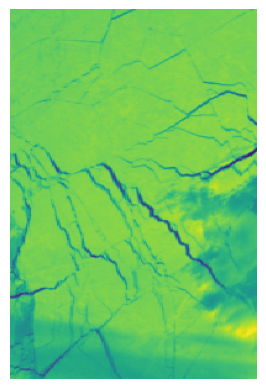

In [ ]:
# Extract channels 1, 2, and 3
channel_1 = roi[:,:,4]  # 0-based indexing for the first channel
rgb_image = np.stack([channel_1], axis=-1) # You can add more channels if you want

# Plotting the RGB image and you will see if it corresponds to the mask
plt.imshow(rgb_image)
plt.axis('off')
plt.show()


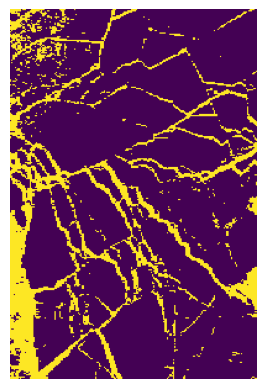

In [ ]:
# You can also plot the mask
plt.imshow(binary_mask)
plt.axis('off')
plt.show()

In [ ]:
## Another check needs to be done is their shape in first two dimensions
print(binary_mask.shape)
print(roi.shape)

(300, 200)
(300, 200, 21)


:Because we are not just using one pixel as a data instance, instead we use also the pixels around that pixel, so one instance would have shape (3,3,21).

In [ ]:
# roi is your data with shape (300, 200, 21)
patches = []

# Iterate over the height and width of the roi, excluding the border pixels
for i in range(1, roi.shape[0] - 1):
    for j in range(1, roi.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = roi[i-1:i+2, j-1:j+2, :]
        patches.append(patch)

# Convert the list of patches to a numpy array
patches_array = np.array(patches)

print(patches_array.shape)


(59004, 3, 3, 21)


Becasue we exclude the border pixels in the previous step, we should do that also for the mask (labels) to avoid inconsisitency.

In [ ]:
# Trim the mask to exclude boundary labels
trimmed_mask = binary_mask[1:-1, 1:-1]

# Flatten the trimmed mask to get a 1D array of labels
labels = trimmed_mask.flatten()

print(labels.shape)


(59004,)


Below shows a standard way to split the data into training and testing set using 'train_test_split' form sci-kit learning package.


In [ ]:
# Assuming patches_array is your X and labels is your y
x_train, x_test, y_train, y_test = train_test_split(patches_array, labels, test_size=0.1, random_state=42)

Having secured the input data, there remains an essential step to address: managing data imbalance. Data imbalance can skew the results and compromise the accuracy of our analysis, thus it's crucial that the two classes are balanced, each having more or less an equivalent quantity. This ensures a more reliable and equitable comparison and analysis. Therefore, we abandom the training and testing sets above and create new ones.


In [ ]:
# Initially, we examine the quantity of each class present in the dataset
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))


{0: 49108, 1: 9896}


In [ ]:
# Identifying the class with the smaller count to balance the number in each class, for example, let it be 9396
num_class = 9896 # Adjust it to the amount you get
# Extract indices of both classes
indices_class_0 = np.where(labels == 0)[0]
indices_class_1 = np.where(labels == 1)[0]

# Randomly sample 9396 indices from class 0
sampled_indices_class_0 = np.random.choice(indices_class_0, num_class, replace=False)

# Combine the sampled indices with indices of class 1
combined_indices = np.concatenate([sampled_indices_class_0, indices_class_1])

# Extract the corresponding patches and labels
balanced_patches = patches_array[combined_indices]
balanced_labels = labels[combined_indices]


# Split the balanced dataset into training and testing sets with a 1:9 ratio
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    balanced_patches, balanced_labels, test_size=0.1, random_state=42
)

# Check the balance in y_train_balanced
unique, counts = np.unique(y_train_balanced, return_counts=True)
print(dict(zip(unique, counts)))


{0: 8912, 1: 8900}


Up until here, we have our data for training and testing ready. You save them using the following code for analysis in the next section.

In [ ]:
pip install numpy

In [ ]:
import numpy as np
np.save ('/content/drive/MyDrive/GEOL0069/2425/Week 2/Week2_AI_Algorithms/X_train_balanced.npy',X_train_balanced)
np.save ('/content/drive/MyDrive/GEOL0069/2425/Week 2/Week2_AI_Algorithms/X_test_balanced.npy',X_test_balanced)
np.save ('/content/drive/MyDrive/GEOL0069/2425/Week 2/Week2_AI_Algorithms/y_train_balanced.npy',y_train_balanced)
np.save ('/content/drive/MyDrive/GEOL0069/2425/Week 2/Week2_AI_Algorithms/y_test_balanced.npy',y_test_balanced)